In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

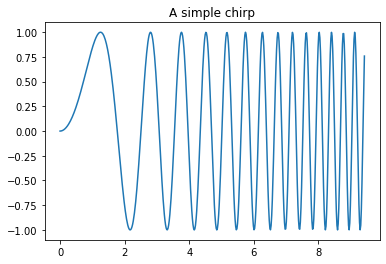

In [2]:
#Checking that plotlib works
x = np.linspace(0, 3*np.pi, 500)
plt.plot(x, np.sin(x**2))
plt.title('A simple chirp')
plt.show()

In [3]:
import tlquantum as tlq
import tensorly as tl
from tqdm import tqdm
from torch import complex64, nn, optim, real
import json

In [2]:
#Global parameters
dt=0.01
device =  'cpu'
approx = 2
ncontraq, ncontral = 2, 2

In [39]:
def prepare_circuit(N, L, axes = ['x', 'z', 'x']):
    #Rotations 
    unitaries = []
    for i in range(L):
        for a in range(3):
            unitaries.append(tlq.UnaryGatesUnitary(N, ncontraq, axis=axes[a], device=device))
        #Star 
        unitaries.append(tlq.Perceptron_U(N, 2, approx, dt=dt, device=device))
        
    return tlq.TTCircuit(unitaries, ncontraq, ncontral)

def kernel(circuit, input, op, criterion): 
    o=circuit.forward_expectation_value(input, op)
    l=criterion(real(o), tl.tensor([0]))
    l.backward()
    K = 0
    for p in circuit.parameters():
        for e in p.grad: 
            K += ((e/l)*(e/l)).item()
    return K

### Four qubits, XZX pulses

In the following cells we employ four qubits, with all the axes turned on, and a depth of $L$ and sample the kernel. 

In [7]:
N=4
L=16
Nsamples=1000
'''
psi0 = tlq.spins_to_tt_state([0 for i in range(N)], device=device,dtype=complex64) # generate generic zero state |00000>
psi0 = tlq.qubits_contract(psi0, ncontraq)
opz = [tlq.IDENTITY().forward()]*(N-1)+[tlq.pauli_z()]
crt=nn.MSELoss()

Ks = []

for i in tqdm(range(Nsamples)):
    c = prepare_circuit(N,L, axes=['z', 'x', 'z'])
    Ks.append(kernel(c, psi0, opz, crt))

    dic = {'N':N, 'L': L, 'Nsamples': Nsamples, 'Ks': Ks}

    with open('Kernels_N4_L16.json', 'w') as ofile: 
        json.dump(dic, ofile)
'''

"\npsi0 = tlq.spins_to_tt_state([0 for i in range(N)], device=device,dtype=complex64) # generate generic zero state |00000>\npsi0 = tlq.qubits_contract(psi0, ncontraq)\nopz = [tlq.IDENTITY().forward()]*(N-1)+[tlq.pauli_z()]\ncrt=nn.MSELoss()\n\nKs = []\n\nfor i in tqdm(range(Nsamples)):\n    c = prepare_circuit(N,L, axes=['z', 'x', 'z'])\n    Ks.append(kernel(c, psi0, opz, crt))\n\n    dic = {'N':N, 'L': L, 'Nsamples': Nsamples, 'Ks': Ks}\n\n    with open('Kernels_N4_L16.json', 'w') as ofile: \n        json.dump(dic, ofile)\n"

### Four qubits, Z pulses

In the following cells we employ four qubits, with only pulses along z turned on, and a depth of $L$ and sample the kernel. 

In [42]:
crt=nn.MSELoss()

Ks = []

for i in tqdm(range(Nsamples)):
    c = prepare_circuit(N,L, axes=['z', 'z', 'z'])
    Ks.append(kernel(c, psi0, opz, crt))

    dic = {'N':N, 'L': L, 'Nsamples': Nsamples, 'Ks': Ks}

    with open('Kernels_N4_L16_Z.json', 'w') as ofile: 
        json.dump(dic, ofile)

100%|█████████████████████████████████████████████████████| 1000/1000 [03:28<00:00,  4.80it/s]


### Four qubits, XZ pulses

In the following cells we employ four qubits, with all pulses along XZ turned on, and a depth of $L$ and sample the kernel. 

In [43]:
crt=nn.MSELoss()

Ks = []

for i in tqdm(range(Nsamples)):
    c = prepare_circuit(N,L, axes=['x', 'x', 'z'])
    Ks.append(kernel(c, psi0, opz, crt))

    dic = {'N':N, 'L': L, 'Nsamples': Nsamples, 'Ks': Ks}

    with open('Kernels_N4_L16_XZ.json', 'w') as ofile: 
        json.dump(dic, ofile)

100%|█████████████████████████████████████████████████████| 1000/1000 [03:26<00:00,  4.85it/s]


In [4]:
#Opening data to plot
with open('Kernels_N4_L16.json', 'r') as infile: 
    data=json.load(infile)

Nsamples=data['Nsamples']
Ks_ZXZ = data['Ks']

#Based on observations, there are few outliers, and so we clean those: 

Ks_ZXZ_clean = []
for k in Ks_ZXZ: 
    if k<2000: 
        Ks_ZXZ_clean.append(k)
        
with open('Kernels_N4_L16_Z.json', 'r') as infile: 
    data=json.load(infile)

Ks_Z = data['Ks']

#Based on observations, there are few outliers, and so we clean those: 

Ks_Z_clean = []
for k in Ks_Z: 
    if k<2000: 
        Ks_Z_clean.append(k)
        
with open('Kernels_N4_L16_XZ.json', 'r') as infile: 
    data=json.load(infile)

Ks_XZ = data['Ks']

#Based on observations, there are few outliers, and so we clean those: 

Ks_XZ_clean = []
for k in Ks_XZ: 
    if k<2000: 
        Ks_XZ_clean.append(k)

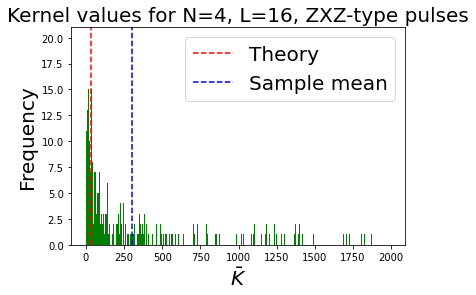

In [9]:
bins = np.arange(min(Ks_ZXZ_clean), max(Ks_ZXZ_clean), 2)
H=2**N
theory = L*(H)**2*2/(H+1)*(4*N+1)/(H**2+1)
mean = sum(Ks_ZXZ_clean)/len(Ks_ZXZ_clean)

plt.figure()
plt.hist(Ks_ZXZ_clean,bins=bins, color='g', alpha=1)
plt.axvline(x=theory, color='red', linestyle='--', label='Theory')
plt.axvline(x=mean, color='blue', linestyle='--', label='Sample mean')
plt.xlabel(r'$\bar{K}$', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.legend(fontsize=20)
plt.title('Kernel values for N=4, L=16, ZXZ-type pulses', fontsize=20)
plt.show()

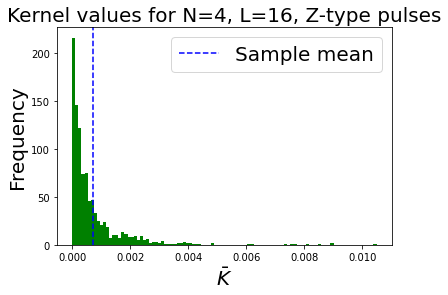

In [10]:
bins = np.linspace(min(Ks_Z_clean), max(Ks_Z_clean),100)
H=2**N
theory = L*(H)**2*2/(H+1)*(0+2)/(H**2+1)
mean = sum(Ks_Z_clean)/len(Ks_Z_clean)

plt.figure()
plt.hist(Ks_Z_clean, bins=bins,color='g', alpha=1)
#plt.axvline(x=theory, color='red', linestyle='--', label='Theory')
plt.axvline(x=mean, color='blue', linestyle='--', label='Sample mean')
plt.xlabel(r'$\bar{K}$', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.title('Kernel values for N=4, L=16, Z-type pulses', fontsize=20)
plt.legend(fontsize=20)
plt.show()

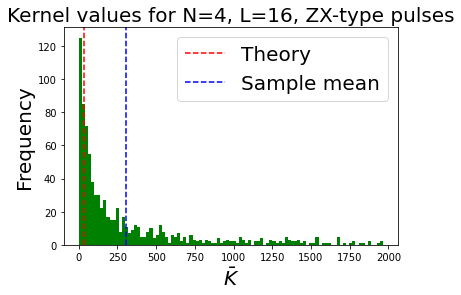

In [11]:
bins = np.linspace(min(Ks_XZ_clean), max(Ks_XZ_clean),100)
H=2**N
theory = L*(H)**2*2/(H+1)*(4*N+2)/(H**2+1)
mean = sum(Ks_XZ_clean)/len(Ks_XZ_clean)

plt.figure()
plt.hist(Ks_XZ_clean, bins=bins,color='g', alpha=1)
plt.axvline(x=theory, color='red', linestyle='--', label='Theory')
plt.axvline(x=mean, color='blue', linestyle='--', label='Sample mean')
plt.xlabel(r'$\bar{K}$', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.legend(fontsize=20)
plt.title('Kernel values for N=4, L=16, ZX-type pulses', fontsize=20)
plt.show()

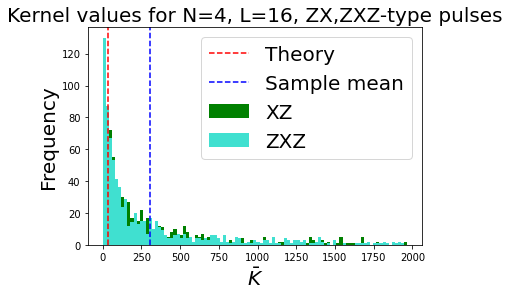

In [13]:
#Histograms of the XZ and ZXZ together
plt.figure()
plt.hist(Ks_XZ_clean, bins=bins,color='g', alpha=1, label='XZ')
plt.hist(Ks_ZXZ_clean, bins=bins,color='turquoise', alpha=1, label='ZXZ')
plt.axvline(x=theory, color='red', linestyle='--', label='Theory')
plt.axvline(x=mean, color='blue', linestyle='--', label='Sample mean')
plt.xlabel(r'$\bar{K}$', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.legend(fontsize=20)
plt.title('Kernel values for N=4, L=16, ZX,ZXZ-type pulses', fontsize=20)
plt.show()